In [42]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor


from sklearn.tree import export_text

import matplotlib.pyplot as plt


In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
data = pd.read_csv(url)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.keys()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
data["log_median_house_value"] = np.log(data.median_house_value)

In [6]:
del data["median_house_value"]

<Axes: >

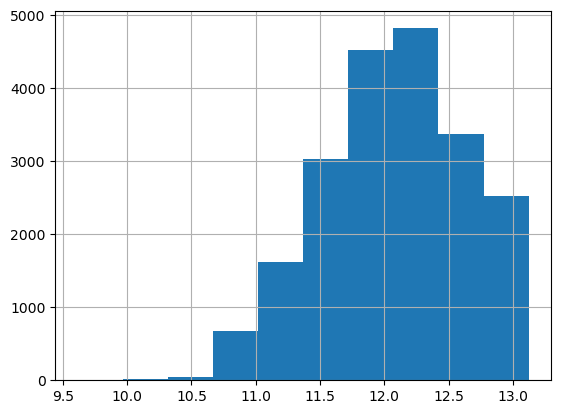

In [7]:
data.log_median_house_value.hist()

In [8]:
TO_PREDICT = ['log_median_house_value']

In [9]:
data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
FILTER = data.ocean_proximity.isin(['<1H OCEAN','INLAND'])

In [11]:
data[FILTER].count()[0]

15687

In [12]:
df = data[FILTER].fillna(0)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               15687 non-null  float64
 1   latitude                15687 non-null  float64
 2   housing_median_age      15687 non-null  float64
 3   total_rooms             15687 non-null  float64
 4   total_bedrooms          15687 non-null  float64
 5   population              15687 non-null  float64
 6   households              15687 non-null  float64
 7   median_income           15687 non-null  float64
 8   ocean_proximity         15687 non-null  object 
 9   log_median_house_value  15687 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [14]:
df.keys()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'log_median_house_value'],
      dtype='object')

In [15]:
# train/test split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [16]:
y_train = df_train['log_median_house_value']
y_val = df_val['log_median_house_value']
y_test = df_test['log_median_house_value']

del df_train['log_median_house_value']
del df_val['log_median_house_value']
del df_test['log_median_house_value']

In [17]:
# divide on CATEGORICAL + NUMERICAL
CATEGORICAL = ['ocean_proximity']
NUMERICAL = [x for x in df_train.keys() if x not in CATEGORICAL]

# check: no other vars
rest = [x for x in df_train.keys() if x not in CATEGORICAL+NUMERICAL]
rest

[]

In [18]:
CATEGORICAL

['ocean_proximity']

In [19]:
NUMERICAL

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

# Q1

In [21]:
# Train a decision tree with some params (max_depth)

def train_dt(df_train, y_train, max_depth=1, random_state=1):
    dicts = df_train[CATEGORICAL + NUMERICAL].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    return dv, model

In [22]:
dv_dt, model_dt = train_dt(df_train, y_train)

In [23]:
# predict on any model and dict vectorizer (Dec Tree or Random Forest)
def predict(df, dv, model):
    dicts = df[CATEGORICAL + NUMERICAL].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)
    return y_pred

In [24]:
y_val_pred = predict(df_val, dv_dt, model_dt)

In [25]:
y_val_pred

array([12.30066427, 12.30066427, 11.60679717, ..., 11.60679717,
       11.60679717, 11.60679717])

In [27]:
y_val[0:3]

19250    12.091223
18693    12.141534
11842    11.478334
Name: log_median_house_value, dtype: float64

In [30]:
# Q1 ans == ocean_proximity
print(export_text(model_dt, feature_names=list(dv_dt.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.30]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



# Q2

In [32]:
# Train a random forest with some params (n_estimators, max_depth)

def train_rf(df_train, 
             y_train, 
             n_estimators=10, 
             max_depth = None,
             random_state=1):
  
    dicts = df_train[CATEGORICAL + NUMERICAL].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = RandomForestRegressor(n_estimators=n_estimators, 
                           random_state=1,
                           max_depth = max_depth,
                           n_jobs=-1)
    model.fit(X_train, y_train)

    return dv, model

In [33]:
dv_rf, model_rf = train_rf(df_train, y_train)

In [34]:
y_val_pred_rf = predict(df_val, dv_rf, model_rf)

In [36]:
# q2 ans = 0.245
rmse = mean_squared_error(y_val, 
                   y_val_pred_rf,
                   squared=False) #this is for RMSE

print(f'RMSE = {rmse}, rounded RMSE = {np.round(rmse,3)}')

RMSE = 0.24539095817174175, rounded RMSE = 0.245


# Q3

In [39]:
%%time
scores = []

for n in range(10, 201, 10):
    dv_rf, model_rf = train_rf(df_train, y_train, n_estimators=n)

    y_val_pred_rf = predict(df_val, dv_rf, model_rf)

    rmse = mean_squared_error(y_val, 
                      y_val_pred_rf,
                      squared=False) #this is for RMSE

    print(f'n_estimators = {n}, RMSE = {rmse}, rounded RMSE = {np.round(rmse,3)}')
    scores.append((n, rmse))

n_estimators = 10, RMSE = 0.24539095817174172, rounded RMSE = 0.245
n_estimators = 20, RMSE = 0.23880223304120454, rounded RMSE = 0.239
n_estimators = 30, RMSE = 0.23657228292954338, rounded RMSE = 0.237
n_estimators = 40, RMSE = 0.23482461327633428, rounded RMSE = 0.235
n_estimators = 50, RMSE = 0.23493852291123088, rounded RMSE = 0.235
n_estimators = 60, RMSE = 0.23484975837216063, rounded RMSE = 0.235
n_estimators = 70, RMSE = 0.2346028007569164, rounded RMSE = 0.235
n_estimators = 80, RMSE = 0.2347055246179976, rounded RMSE = 0.235
n_estimators = 90, RMSE = 0.23446978540671826, rounded RMSE = 0.234
n_estimators = 100, RMSE = 0.2342999592706307, rounded RMSE = 0.234
n_estimators = 110, RMSE = 0.23431086680156346, rounded RMSE = 0.234
n_estimators = 120, RMSE = 0.23403792713007845, rounded RMSE = 0.234
n_estimators = 130, RMSE = 0.2338571152765766, rounded RMSE = 0.234
n_estimators = 140, RMSE = 0.23367933590798595, rounded RMSE = 0.234
n_estimators = 150, RMSE = 0.23356957360170866,

In [40]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

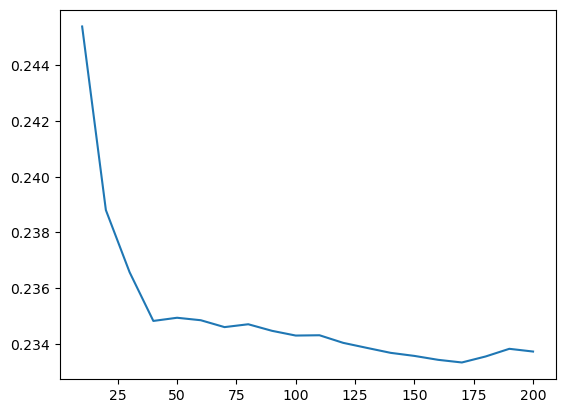

In [43]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

# Q4

In [44]:
%%time

scores2 = []

for d in [10, 15, 20, 25]:
  rmses = []
  for n in range(10, 201, 10):
    dv_rf, model_rf = train_rf(df_train, y_train, n_estimators=n, max_depth=d)

    y_val_pred_rf = predict(df_val, dv_rf, model_rf)

    rmse = mean_squared_error(y_val, 
                      y_val_pred_rf,
                      squared=False) #this is for RMSE

    print(f'n_estimators = {n}, max_depth={d},  RMSE = {rmse}, rounded RMSE = {np.round(rmse,3)}')
    scores2.append((n, d, rmse))
    rmses.append(rmse)
  
  print('================')
  print(f'max_depth={d} , mean_RMSE={np.mean(rmses)}')
  print('================')

n_estimators = 10, max_depth=10,  RMSE = 0.2510311868876959, rounded RMSE = 0.251
n_estimators = 20, max_depth=10,  RMSE = 0.2473652137286534, rounded RMSE = 0.247
n_estimators = 30, max_depth=10,  RMSE = 0.2463256927916003, rounded RMSE = 0.246
n_estimators = 40, max_depth=10,  RMSE = 0.2450639489651681, rounded RMSE = 0.245
n_estimators = 50, max_depth=10,  RMSE = 0.24540564824985506, rounded RMSE = 0.245
n_estimators = 60, max_depth=10,  RMSE = 0.24543474635432927, rounded RMSE = 0.245
n_estimators = 70, max_depth=10,  RMSE = 0.24552504920512955, rounded RMSE = 0.246
n_estimators = 80, max_depth=10,  RMSE = 0.24567007161399168, rounded RMSE = 0.246
n_estimators = 90, max_depth=10,  RMSE = 0.2455322760665391, rounded RMSE = 0.246
n_estimators = 100, max_depth=10,  RMSE = 0.24534407752120782, rounded RMSE = 0.245
n_estimators = 110, max_depth=10,  RMSE = 0.24525395340474349, rounded RMSE = 0.245
n_estimators = 120, max_depth=10,  RMSE = 0.24503298302842572, rounded RMSE = 0.245
n_esti

In [45]:
df_scores2 = pd.DataFrame(scores2, columns=['n_estimators', 'max_depth', 'rmse'])

In [46]:
# check:
# # answer to q4 ==> best is max_depth==20
# ================
# max_depth=10 , mean_RMSE=0.24546787850184826
# max_depth=15 , mean_RMSE=0.2356819990521785
# max_depth=20 , mean_RMSE=0.23456015774912164
# max_depth=25 , mean_RMSE=0.23511193988971288
# ================

# answer to question 4: group by 'max_depth' and find mean rmse
df_scores2.groupby(by='max_depth')['rmse'].mean()

max_depth
10    0.245468
15    0.235682
20    0.234560
25    0.235112
Name: rmse, dtype: float64

# Q5

In [47]:
dv_rf, model_rf = train_rf(df_train, 
                           y_train, 
                           n_estimators=10, 
                           max_depth=20,
                           random_state=1)

In [48]:
model_rf.feature_importances_

array([0.01455543, 0.03032345, 0.10151453, 0.08709334, 0.33574968,
       0.03529711, 0.33098244, 0.02834515, 0.01515447, 0.0209844 ])

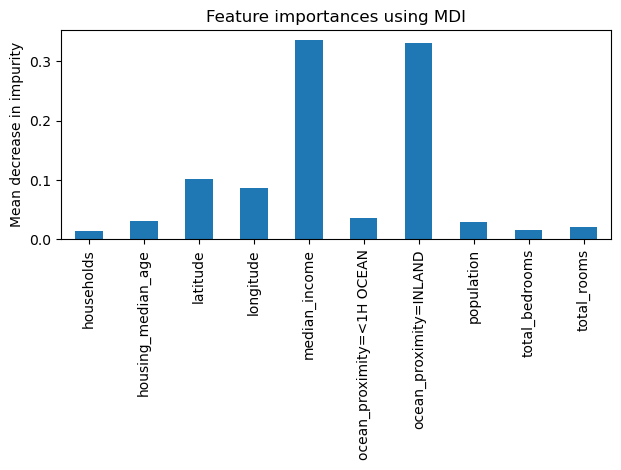

In [49]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(model_rf.feature_importances_, index=list(dv_rf.get_feature_names_out()))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
# for i, element in enumerate(model_rf.feature_importances_):
#     print(i, list2[i], list3[i])

res = []

for f,i in zip(list(dv_rf.get_feature_names_out()),model_rf.feature_importances_):
  res.append((f,i))

In [51]:
# features importance sorted ascending ==> median_income is the most important
sorted(res, key=lambda x: x[1])

[('households', 0.014555433639129103),
 ('total_bedrooms', 0.015154470388830506),
 ('total_rooms', 0.02098439729588686),
 ('population', 0.028345150071234507),
 ('housing_median_age', 0.030323451392227505),
 ('ocean_proximity=<1H OCEAN', 0.035297113178256095),
 ('longitude', 0.08709333928795938),
 ('latitude', 0.10151452760305246),
 ('ocean_proximity=INLAND', 0.33098243681580797),
 ('median_income', 0.33574968032761554)]

# Q6

In [52]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 8.4 MB/s eta 0:00:00:00:0100:01


In [53]:
import xgboost as xgb

In [54]:
dicts = df_train[CATEGORICAL + NUMERICAL].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

dicts_val = df_val[CATEGORICAL + NUMERICAL].to_dict(orient='records')
dv_val = DictVectorizer(sparse=False)
X_val = dv_val.fit_transform(dicts_val)

In [55]:
# hack for features names to be correct
features = [x.replace('=','_eq_').replace('<','lt_') for x in list(dv.get_feature_names_out())]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_eq_lt_1H OCEAN',
 'ocean_proximity_eq_INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [56]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [57]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [58]:
xgb_params_eta_eq_03 = xgb_params.copy()
xgb_params_eta_eq_03

{'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'nthread': 8,
 'seed': 1,
 'verbosity': 1}

In [60]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [61]:
model_xgb_eta_eq_0_3 = xgb.train(xgb_params_eta_eq_03, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:0.44351	val-rmse:0.44250
[5]	train-rmse:0.25338	val-rmse:0.27463


[10]	train-rmse:0.21445	val-rmse:0.25179
[15]	train-rmse:0.19858	val-rmse:0.24523
[20]	train-rmse:0.18524	val-rmse:0.23978
[25]	train-rmse:0.17757	val-rmse:0.23830
[30]	train-rmse:0.16888	val-rmse:0.23571
[35]	train-rmse:0.16113	val-rmse:0.23416
[40]	train-rmse:0.15542	val-rmse:0.23319
[45]	train-rmse:0.14941	val-rmse:0.23190
[50]	train-rmse:0.14536	val-rmse:0.23225
[55]	train-rmse:0.14150	val-rmse:0.23197
[60]	train-rmse:0.13719	val-rmse:0.23139
[65]	train-rmse:0.13260	val-rmse:0.23158
[70]	train-rmse:0.12943	val-rmse:0.23068
[75]	train-rmse:0.12555	val-rmse:0.23039
[80]	train-rmse:0.12192	val-rmse:0.22886
[85]	train-rmse:0.11854	val-rmse:0.22888
[90]	train-rmse:0.11504	val-rmse:0.22877
[95]	train-rmse:0.11266	val-rmse:0.22865
[99]	train-rmse:0.11043	val-rmse:0.22873


In [62]:
xgb_params_eta_eq_01= xgb_params.copy()

xgb_params_eta_eq_01['eta']=0.1
xgb_params_eta_eq_01

{'eta': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'nthread': 8,
 'seed': 1,
 'verbosity': 1}

In [63]:
model_xgb_eta_eq_0_1 = xgb.train(xgb_params_eta_eq_01, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:0.52449	val-rmse:0.52045
[5]	train-rmse:0.37823	val-rmse:0.38152
[10]	train-rmse:0.30326	val-rmse:0.31427
[15]	train-rmse:0.26539	val-rmse:0.28380
[20]	train-rmse:0.24512	val-rmse:0.26882
[25]	train-rmse:0.23027	val-rmse:0.25997
[30]	train-rmse:0.21887	val-rmse:0.25267
[35]	train-rmse:0.21020	val-rmse:0.24827
[40]	train-rmse:0.20392	val-rmse:0.24539
[45]	train-rmse:0.19814	val-rmse:0.24293
[50]	train-rmse:0.19215	val-rmse:0.24020
[55]	train-rmse:0.18809	val-rmse:0.23878
[60]	train-rmse:0.18457	val-rmse:0.23791
[65]	train-rmse:0.18064	val-rmse:0.23698
[70]	train-rmse:0.17741	val-rmse:0.23622
[75]	train-rmse:0.17468	val-rmse:0.23510
[80]	train-rmse:0.17242	val-rmse:0.23454
[85]	train-rmse:0.17014	val-rmse:0.23404
[90]	train-rmse:0.16798	val-rmse:0.23332
[95]	train-rmse:0.16562	val-rmse:0.23276
[99]	train-rmse:0.16323	val-rmse:0.23209


In [65]:
# rmse ETA=0.3  : 0.228 ==> BETTER
# rmse ETA=0.1  : 0.232

print('Fin. This is the end')

Fin. This is the end
